This code uses built-in functions from the Image class in PIL to execute isometries on a given image. It snapshots the lens view after each isometry, then puts those images into a numpy array. It then calculates the persistent homology of the data. For different images, 'lens_sz' and 'intervals' should be adjusted.

In [139]:
# Imports
import numpy as np
import math
from hausdorff import hausdorff_distance
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances

# For image and video manipulation
from PIL import Image
from PIL import ImageEnhance
from PIL import ImageFilter
import PIL
import glob

# Persistent homology
from ripser import ripser
from persim import plot_diagrams
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from gudhi.cover_complex import MapperComplex, GraphInducedComplex, NerveComplex
from gudhi import bottleneck_distance
import gudhi as gd
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
 

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Grab image from files
c1_names = glob.glob('../images/*C1*.png')
c4_names = glob.glob('../images/*C4*.png')
test_name = glob.glob('../images/test*.png')
print(c1_names)
print(c4_names)
img = Image.open(c1_names[5])
img = img.convert('L')

img2 = Image.open(c1_names[5])
img2 = img2.convert('L')
img2 = img2.resize((3809*3,1614*3), resample = PIL.Image.Resampling.BOX)

img3 = Image.open(c1_names[4])
img4 = Image.open(c4_names[0])
img4 = img4.convert('L')

testimg = Image.open(test_name[0]).convert('L')
#img = img.resize((540,331), resample = PIL.Image.Resampling.BOX)
#img = ImageEnhance.Sharpness(img.convert('RGB'))
#img = img.enhance(0.1)
#img = img.filter(ImageFilter.GaussianBlur(1))
# with np.printoptions(threshold=np.inf):
#     print(np.asarray(img))
#img.show()

['../images\\C1 curly arrow.png', '../images\\C1 horsehex.png', '../images\\C1 horseshoe.png', '../images\\C1 spiral.png', '../images\\C1arrows.png', '../images\\C1bigarrows.png']
['../images\\C4pinwheel.png']


In [163]:
# wrapper for hausdorff so we can feed it into ripser
def hausdorff_wrapper(lensSize, metric='manhattan'):
    (x, y) = lensSize
    def second_layer(arrayOne, arrayTwo):
        arrayOne = arrayOne.reshape((y,x))
        arrayTwo = arrayTwo.reshape((y,x))
        return hausdorff_distance(arrayOne, arrayTwo, distance=metric)
    return second_layer

In [162]:
def hausdorff_test(lensSize, metric='manhattan'):
    (x, y) = lensSize
    def second_layer(arrayOne, arrayTwo):
        arrayOne = arrayOne.reshape((y,x))
        Image.fromarray(arrayOne).show()
        arrayTwo = arrayTwo.reshape((y,x))
        return hausdorff_distance(arrayOne, arrayTwo, distance=metric)
    return second_layer
test_img = img4.crop((0,0,20,30))
test_img.show()
test_arr = np.asarray(test_img)
hausdorff_test((20,30))(test_arr, test_arr)

0.0

In [17]:
# if you want to store generated images in a file
def store_snapshots(image_ls):
    counter = 0
    for img1 in image_ls:
        img1.save("images/dataset/"+str(counter)+".png")
        counter+=1

In [18]:
# see how many points are persisting
def persistingPoints(res,simpDim = 1):
    Hn = res['dgms'][simpDim].tolist() # all intervals in simpDim
    d = []
    for pair in Hn: 
        d.append(pair[1] - pair[0]) # finding lengths of intervals in Hn
    d.sort(reverse = True) # sorting from longest to shortest intervals
    print(d[:6])

translation_snapshot() translates the plane by a vector a and returns the lens view afterwards. It takes an image (Image), the lens size (int), and the translation vector (tuple) that shifts the plane in the direction of the vector. 

In [21]:
def translation_snapshot(img, lens_sz, a):
    (x,y)=a
    (lx, ly) = lens_sz
    x=-x #since x and y will shift the crop and not the plane, need to make sure it is going in right direction
    (length, height) = img.size
    lens_corner_x=length/2.0 - lx/2.0 +x
    lens_corner_y=height/2.0 - ly/2.0 +y
    ret_img = img.crop((lens_corner_x,lens_corner_y, lens_corner_x+lx, lens_corner_y+ly))
    
    #make sure didn't fall off of the image
    (ret_length, ret_height) = ret_img.size
#     if (lens_corner_x<0 or lens_corner_y<0 or lens_corner_x+lx>length or lens_corner_y+ly>height):
#         print("I came off the page!")
#         return False
    return ret_img

In [10]:
def fixedIso(img, lens_sz, degree_num, translation_num, zero_translations, lens_crunch = False,rng_seed = 451):
    
    image_list = []
    rng = np.random.default_rng(rng_seed)
    
    lens_range = ((min(img.size)/math.sqrt(2))-lens_sz)/2.0
    degrees = np.linspace(0, 360, degree_num)
    intervals_x = np.linspace((-1)*lens_range, lens_range, translation_num)
    intervals_y = np.linspace((-1)*lens_range, lens_range, translation_num)
    
    for d in degrees:
        rot = img.rotate(d,resample = PIL.Image.Resampling.NEAREST)
        #print(d)
        for x in intervals_x:
            for y in intervals_y:
                if lens_crunch == False:
                        image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
                else:
                        image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                          math.ceil(lens_sz / crunch_kernel)),
                                                                                         resample = PIL.Image.Resampling.BOX))

    for j in range(zero_translations):
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    return image_list

In [11]:
def transIso(img, lens_sz, degree_num, translation_num, zero_translations, lens_crunch = False,rng_seed = 451):
    
    image_list = []
    rng = np.random.default_rng(rng_seed)
    
    lens_range = ((min(img.size)/math.sqrt(2))-lens_sz)/2.0
    degrees = np.linspace(0, 360, degree_num)
    
    for d in degrees:
        rot = img.rotate(d,resample = PIL.Image.Resampling.NEAREST)
        #print(d)
        for j in range(translation_num):
            x = rng.integers((-1)*lens_range, lens_range)
            y = rng.integers((-1)*lens_range, lens_range)
            if lens_crunch == False:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
            else:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))

    for j in range(zero_translations):
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    return image_list

In [12]:
def randIso(img, lens_sz, degree_num, translation_num, zero_translations, lens_crunch = False,rng_seed = 451):
    
    image_list = []
    rng = np.random.default_rng(rng_seed)
    
    lens_range = ((min(img.size)/math.sqrt(2))-lens_sz)/2.0
    degrees = rng.uniform(0.0,360.0, size = degree_num)
    j = 0
    
    for d in degrees:
        #print(j)
        j = j + 1
        rot = img.rotate(d,resample = PIL.Image.Resampling.NEAREST)
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    for k in range(zero_translations):
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    return image_list

In [13]:
def imgListToArray(img_list):
    data = []
    x=0
    for i in image_list:
        img_arr = np.asarray(i)
        data.append(img_arr.reshape(-1))
    data = np.array(data)
    return data

In [23]:
data = []

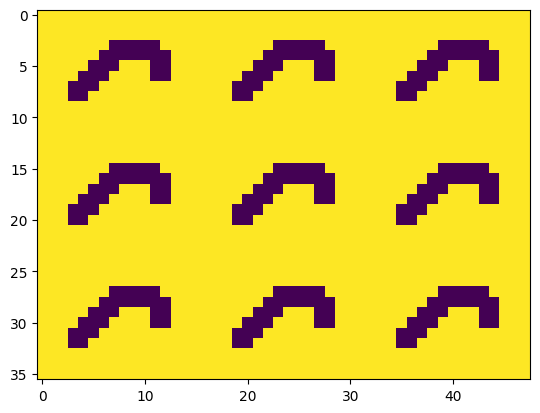

In [14]:
plt.figure()
plt.imshow(testimg)
plt.show()

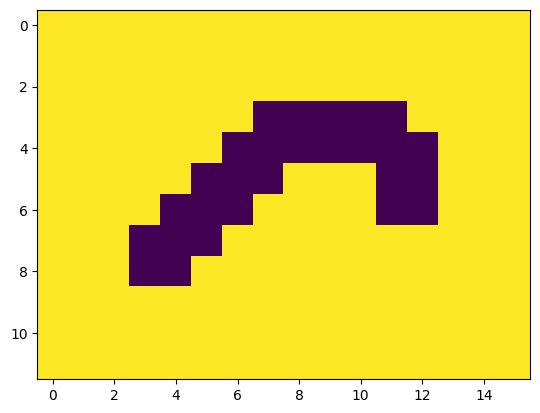

In [24]:
shower = translation_snapshot(testimg, (16,12),(0,0))

shower = np.asarray(shower)
data.append(shower.reshape(-1))

plt.figure()
plt.imshow(shower)
plt.show()

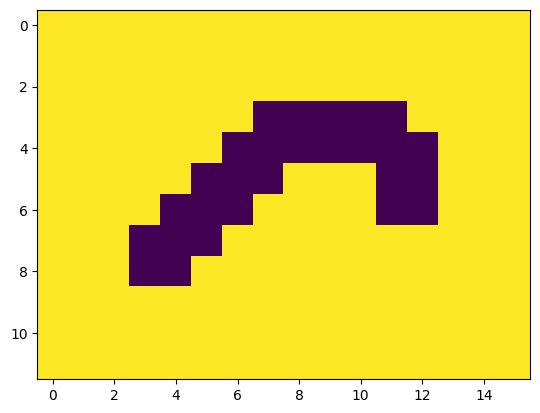

In [28]:
plt.figure()
plt.imshow(data[0].reshape(12,16))
plt.show()

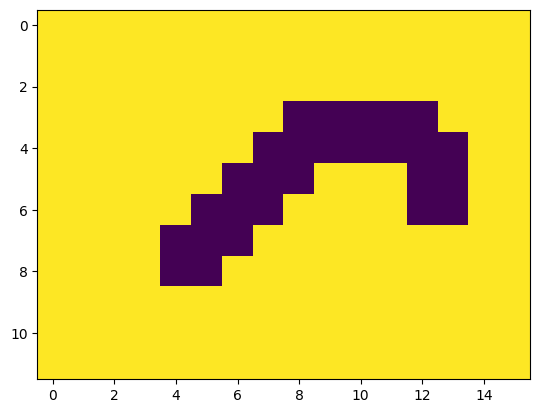

In [29]:
shower = translation_snapshot(testimg, (16,12),(1,0))

shower = np.asarray(shower)
data.append(shower.reshape(-1))

plt.figure()
plt.imshow(shower)
plt.show()

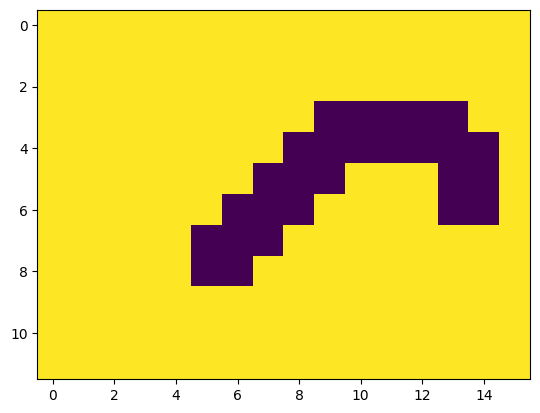

In [30]:
shower = translation_snapshot(testimg, (16,12),(2,0))

shower = np.asarray(shower)
data.append(shower.reshape(-1))

plt.figure()
plt.imshow(shower)
plt.show()

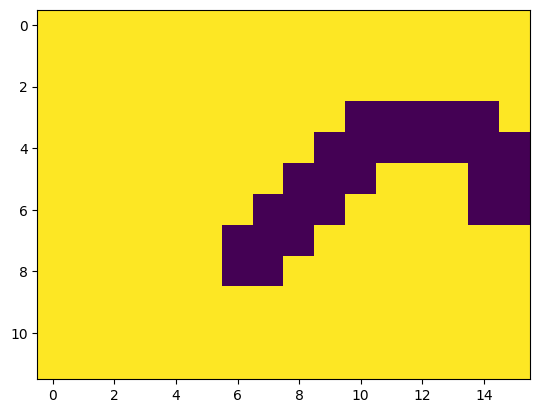

In [31]:
shower = translation_snapshot(testimg, (16,12),(3,0))

shower = np.asarray(shower)
data.append(shower.reshape(-1))

plt.figure()
plt.imshow(shower)
plt.show()

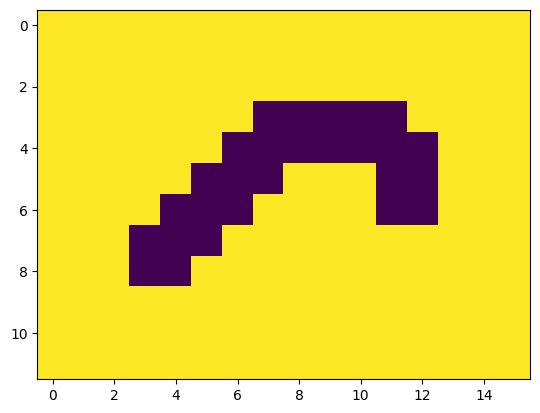

In [64]:
shower = translation_snapshot(testimg, (16,12),(16,0))

shower = np.asarray(shower)
data.append(shower.reshape(-1))

plt.figure()
plt.imshow(shower)
plt.show()

In [67]:
D = pairwise_distances(data)

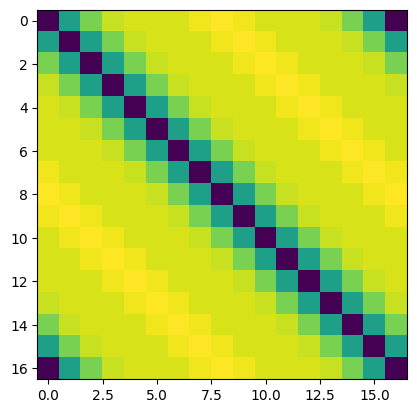

In [68]:
plt.figure()
plt.imshow(D)
plt.show()

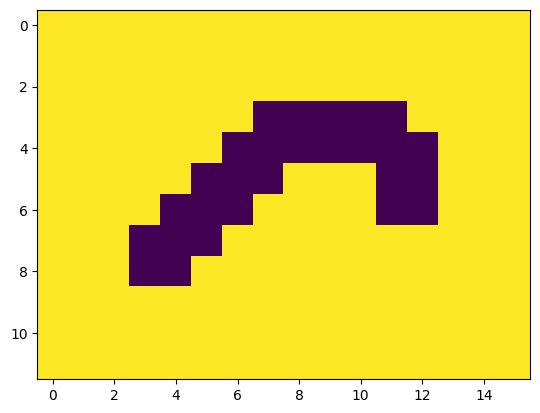

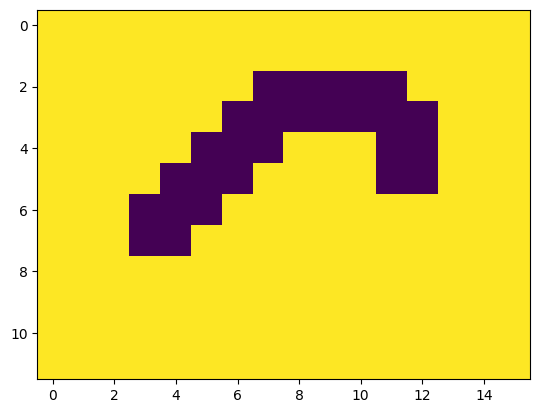

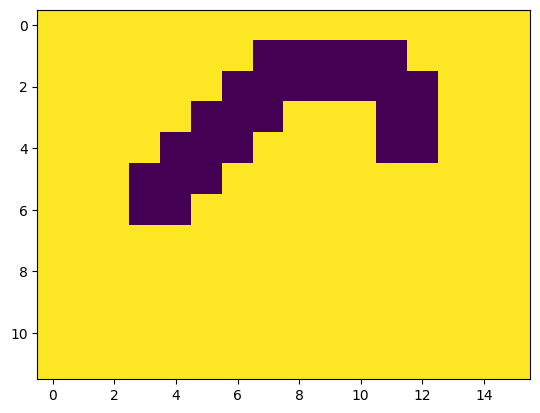

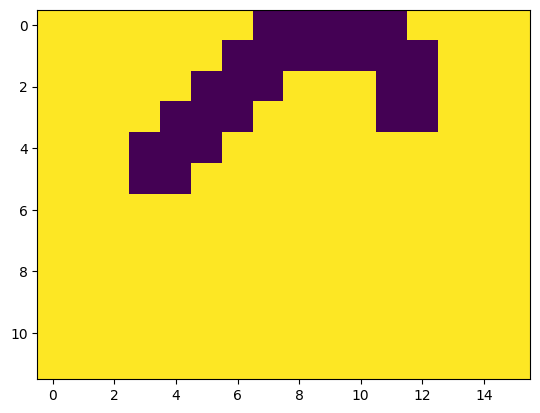

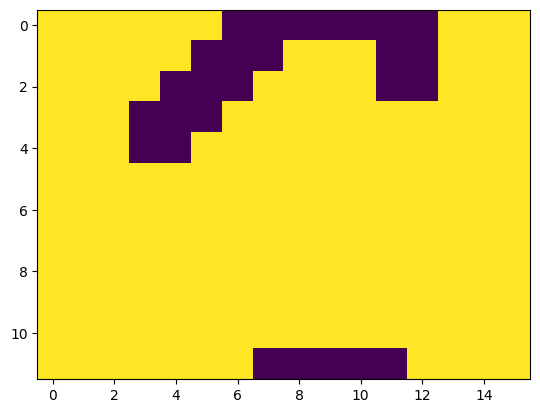

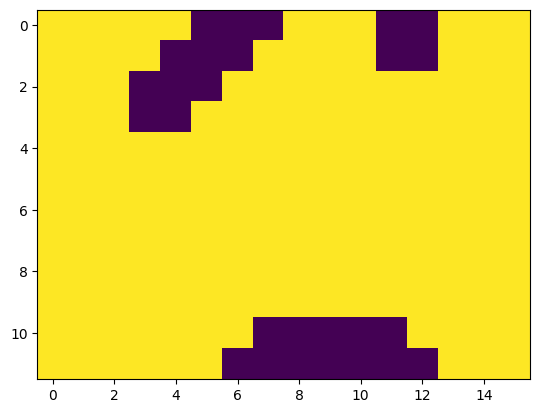

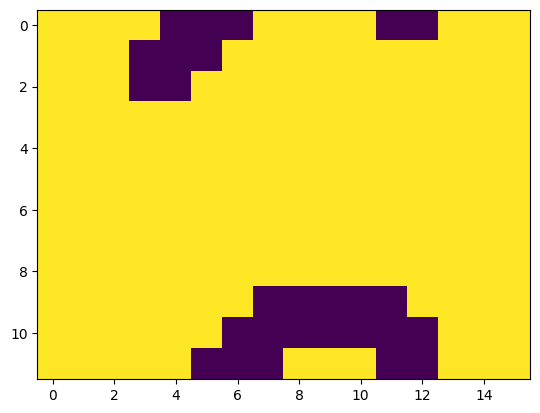

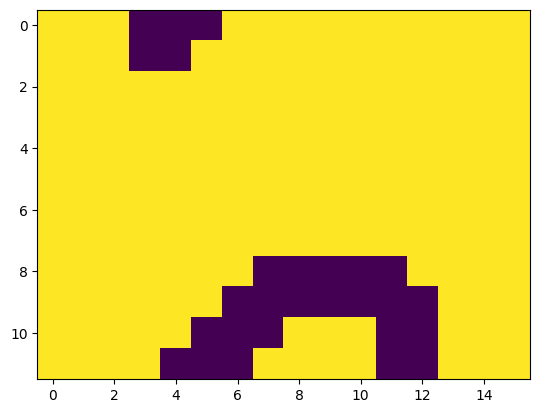

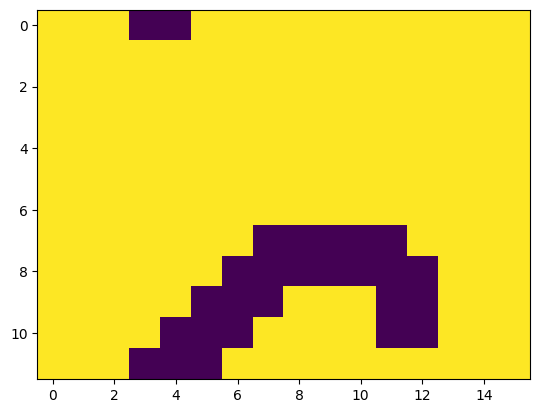

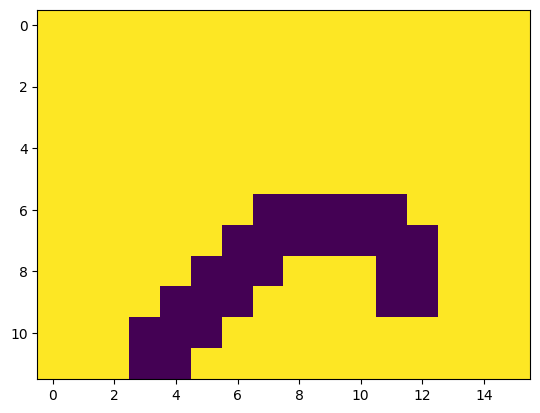

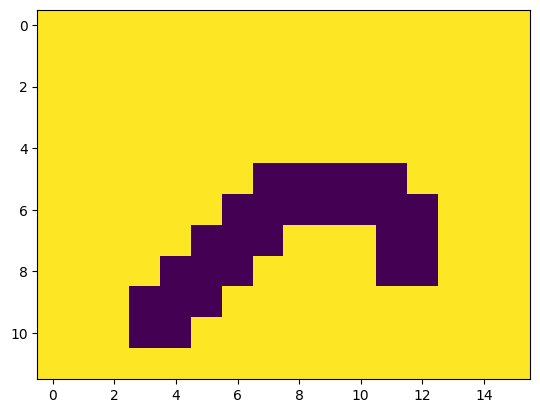

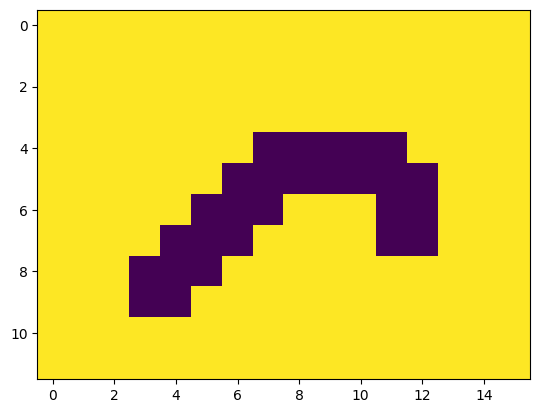

In [79]:
for i in range(12):
    shower = translation_snapshot(testimg, (16,12),(0,i))
    shower = np.asarray(shower)
    data.append(shower.reshape(-1))
    plt.figure()
    plt.imshow(shower)
    plt.show()

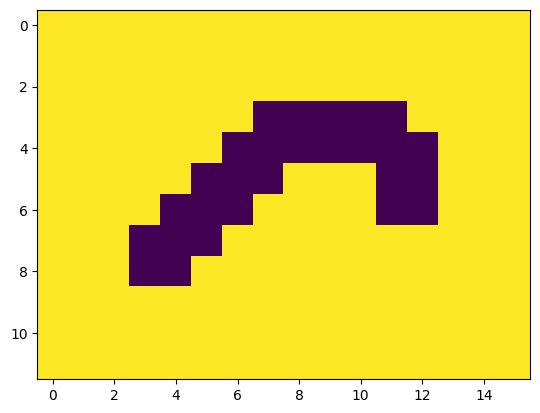

In [80]:
shower = translation_snapshot(testimg, (16,12),(0,12))
shower = np.asarray(shower)
data.append(shower.reshape(-1))
plt.figure()
plt.imshow(shower)
plt.show()

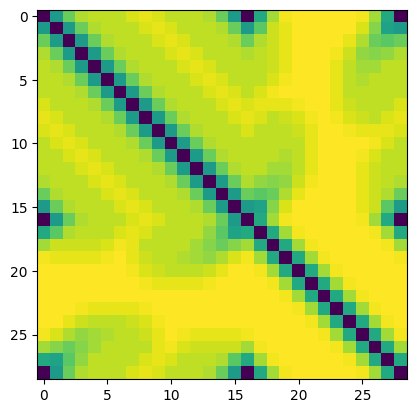

In [86]:
D2 = pairwise_distances(data)
plt.figure()
plt.imshow(D2)
plt.show()

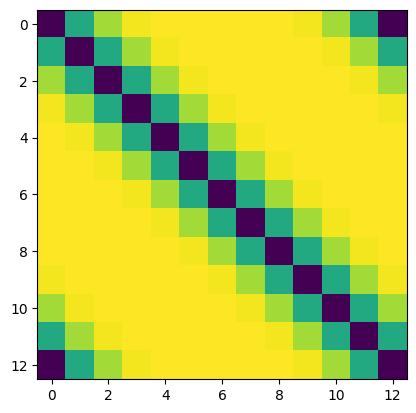

In [89]:
D3 = pairwise_distances(data[16:29])
plt.figure()
plt.imshow(D3)
plt.show()

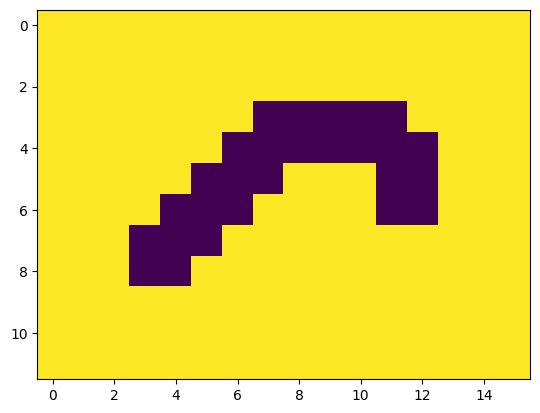

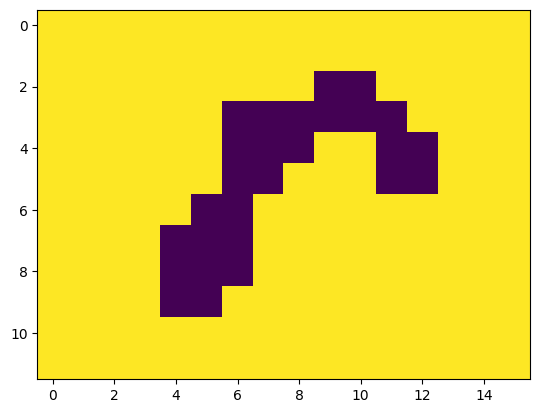

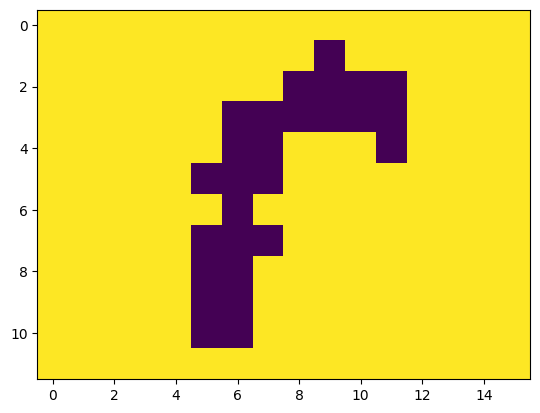

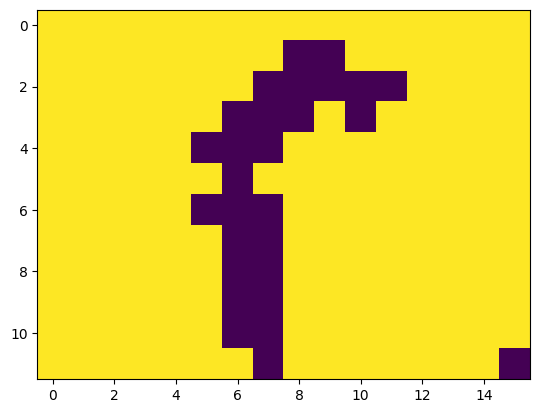

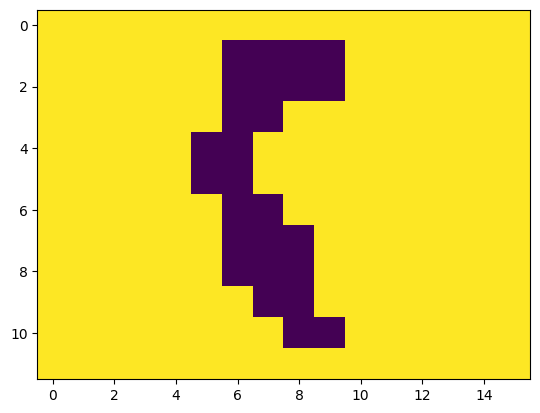

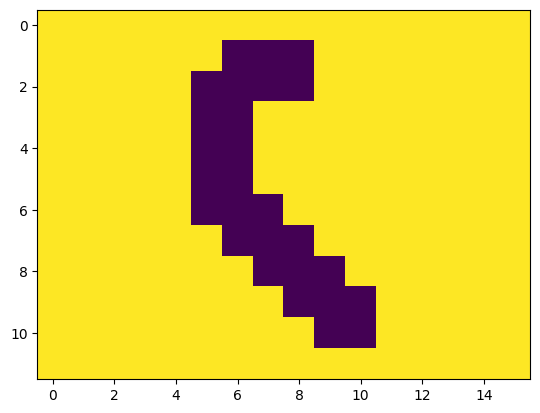

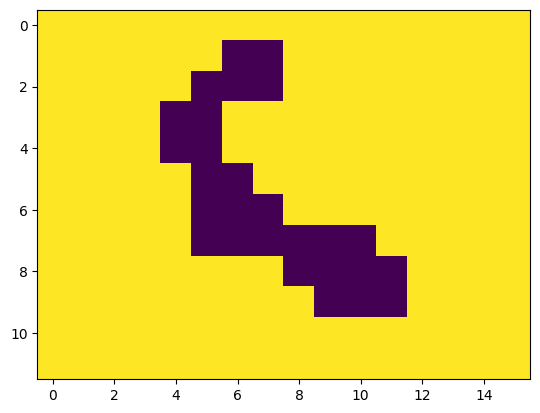

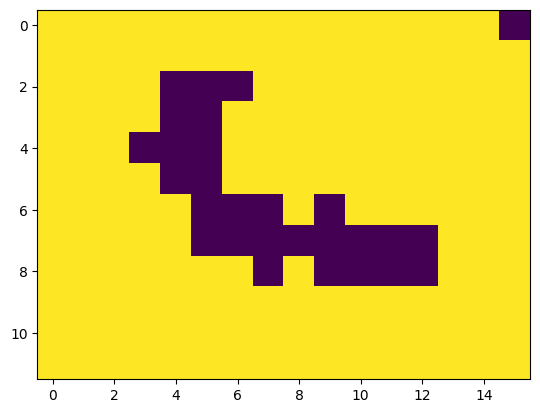

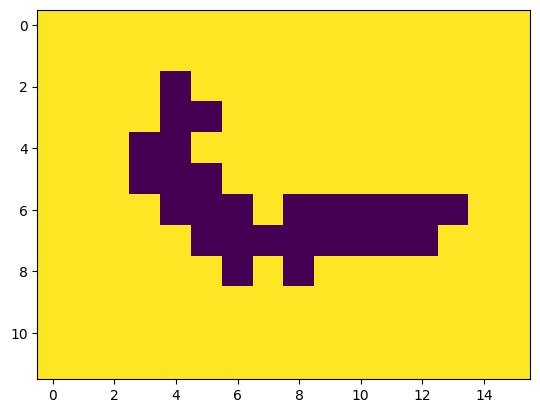

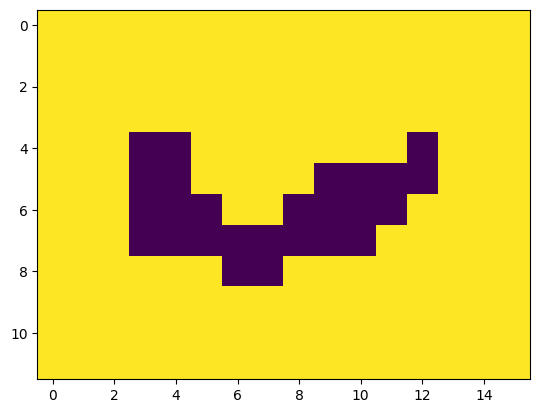

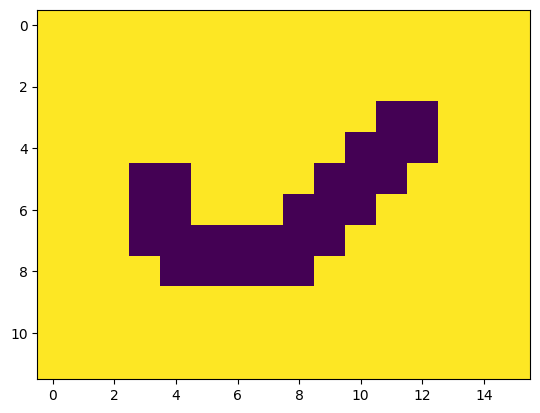

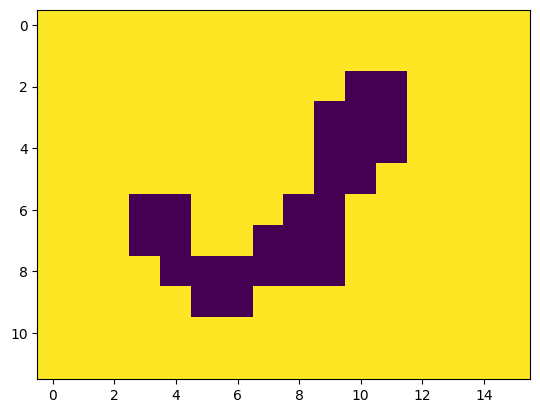

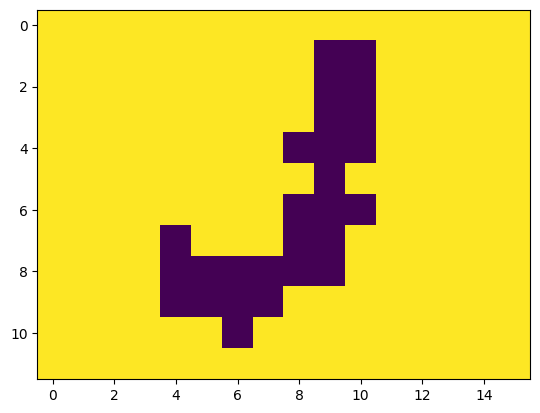

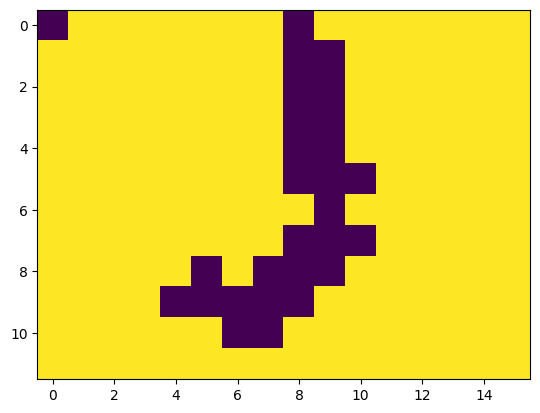

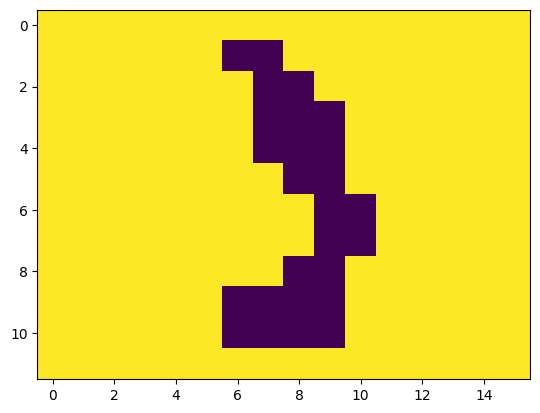

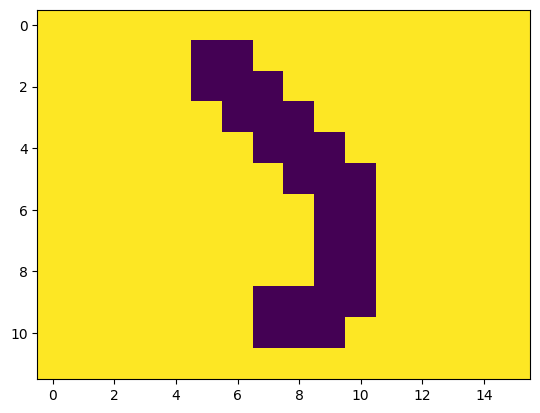

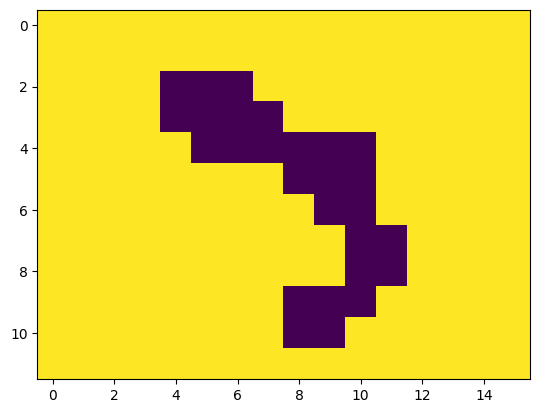

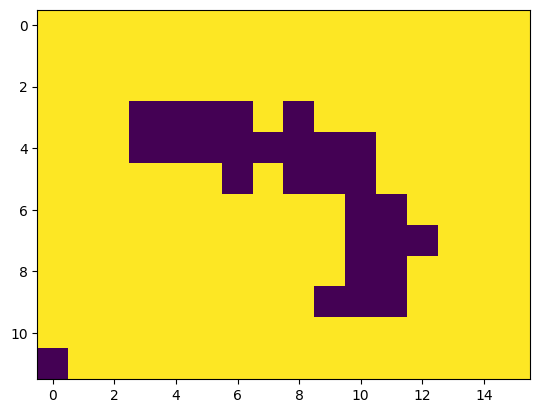

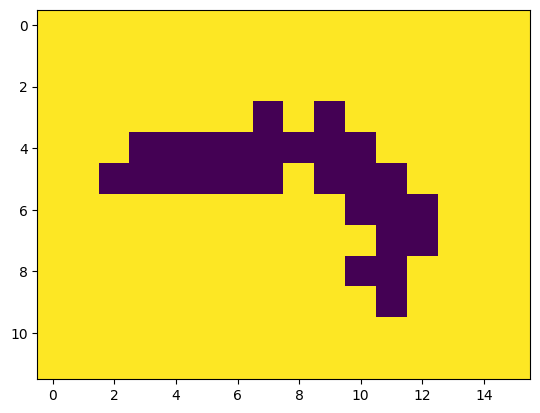

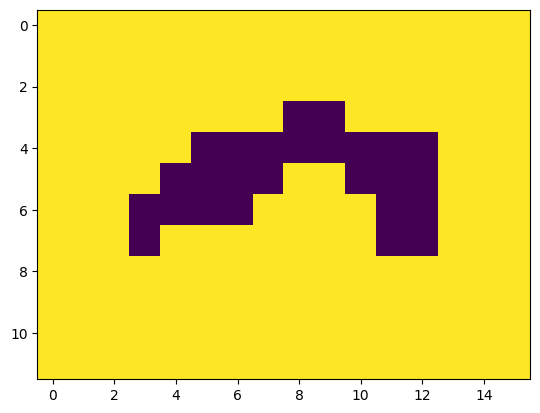

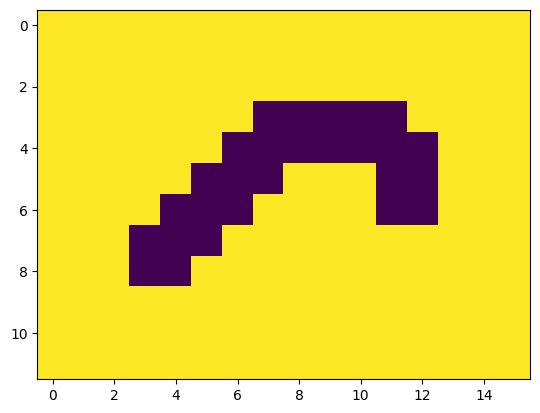

In [92]:
j = np.arange(0,361,18)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.NEAREST)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    data.append(shower.reshape(-1))
    plt.figure()
    plt.imshow(shower)
    plt.show()

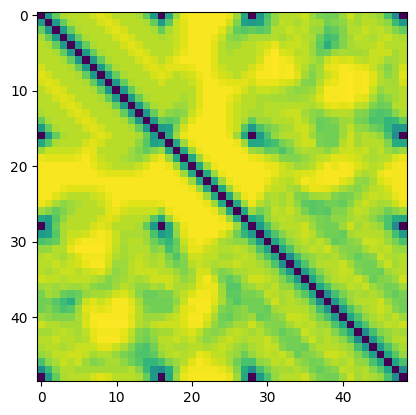

In [101]:
D4 = pairwise_distances(data)
plt.figure()
plt.imshow(D4)
plt.show()

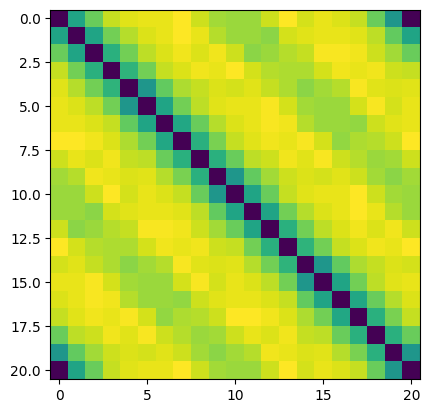

In [104]:
D5 = pairwise_distances(data[28:49])
plt.figure()
plt.imshow(D5)
plt.show()

In [106]:
D5.shape

(21, 21)

[592.7615966796875, 551.083984375, 410.7098388671875, 355.0484619140625, 108.606689453125, 69.28076171875]


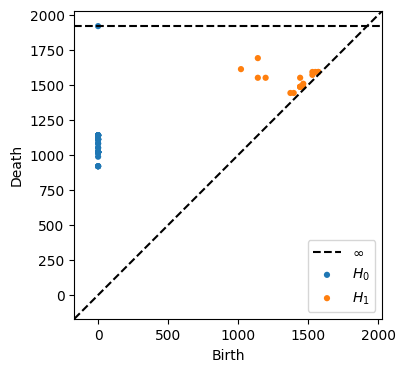

In [118]:
ripsdata = np.array(data)
res = ripser(ripsdata, maxdim=1,  coeff =2, metric = 'euclidean')
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

In [147]:
data2 = []

for i in range(13):
    shower = translation_snapshot(testimg, (16,12),(0,i))
    shower = np.asarray(shower)
    data2.append(shower.reshape(-1))

In [148]:
for i in range(17):
    shower = translation_snapshot(testimg, (16,12),(i,0))
    shower = np.asarray(shower)
    data2.append(shower.reshape(-1))

In [149]:
j = np.arange(0,361,5)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.NEAREST)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    data2.append(shower.reshape(-1))

[926.484619140625, 551.925537109375, 512.1942138671875, 355.0484619140625, 133.3074951171875, 93.1646728515625]


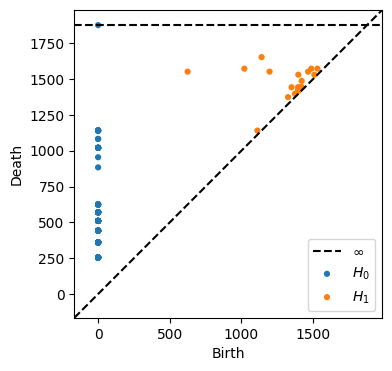

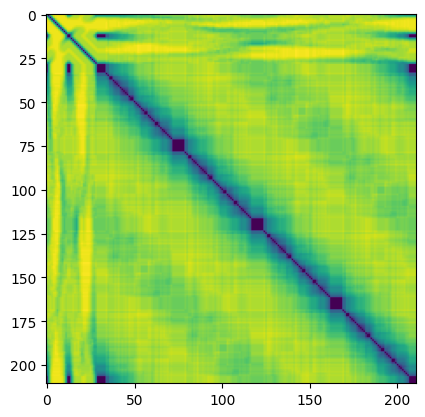

In [152]:
ripsdata2 = np.array(data2)
res = ripser(ripsdata2, maxdim=1,  coeff =2, metric = 'euclidean')
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)
plt.figure()
plt.imshow(res['dperm2all'])
plt.show()

In [128]:
rotCirc = 0.
for i in range(20):
    rotCirc = rotCirc + np.linalg.norm(data[i+ 28]-data[i + 29])
print( rotCirc)

14759.034647942077


[926.484619140625, 551.925537109375, 512.1942138671875, 355.0484619140625, 133.3074951171875, 93.1646728515625]


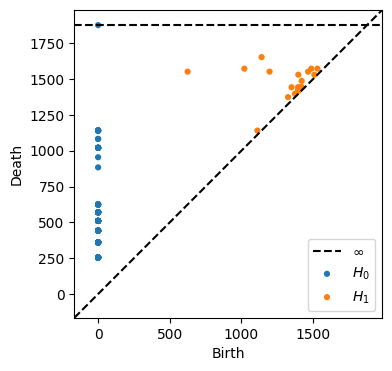

In [151]:
data2 = []

for i in range(13):
    shower = translation_snapshot(testimg, (16,12),(0,i))
    shower = np.asarray(shower)
    data2.append(shower.reshape(-1))
    
for i in range(17):
    shower = translation_snapshot(testimg, (16,12),(i,0))
    shower = np.asarray(shower)
    data2.append(shower.reshape(-1))
    
j = np.arange(0,361,2)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.NEAREST)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    data2.append(shower.reshape(-1))

ripsdata2 = np.array(data2)
res = ripser(ripsdata2, maxdim=1,  coeff =2, metric = 'euclidean')
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

[7905.0, 5610.0, 5610.0, 3825.0, 1530.0, 1020.0]


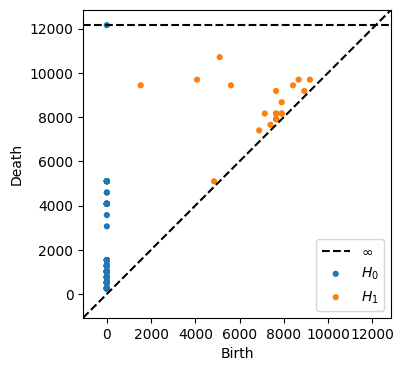

In [166]:
data2 = []

for i in range(13):
    shower = translation_snapshot(testimg, (16,12),(0,i))
    shower = np.asarray(shower)
    data2.append(shower.reshape(-1))
    
for i in range(17):
    shower = translation_snapshot(testimg, (16,12),(i,0))
    shower = np.asarray(shower)
    data2.append(shower.reshape(-1))
    
j = np.arange(0,361,2)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.NEAREST)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    data2.append(shower.reshape(-1))

ripsdata2 = np.array(data2)
res = ripser(ripsdata2, maxdim=1,  coeff =2, metric = 'manhattan')
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

[149.37554931640625, 114.619873046875, 105.62445068359375, 105.62445068359375, 105.62445068359375, 81.04849243164062]


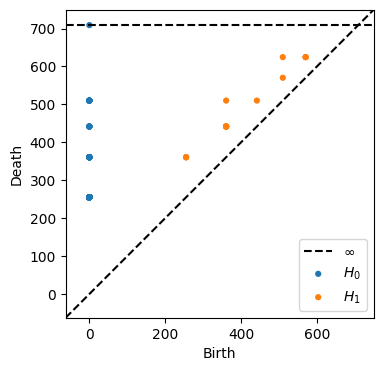

In [173]:
data2 = []

for i in range(13):
    shower = translation_snapshot(testimg, (16,12),(0,i))
    shower = np.asarray(shower)
    data2.append(shower.reshape(-1))
    
for i in range(13):
    shower = translation_snapshot(testimg, (16,12),(0,-i))
    shower = np.asarray(shower)
    data2.append(shower.reshape(-1))
    
for i in range(17):
    shower = translation_snapshot(testimg, (16,12),(i,0))
    shower = np.asarray(shower)
    data2.append(shower.reshape(-1))
    
for i in range(17):
    shower = translation_snapshot(testimg, (16,12),(-i,0))
    shower = np.asarray(shower)
    data2.append(shower.reshape(-1))

    
for i in range(13):
    shower = translation_snapshot(testimg, (16,12),(i,i))
    shower = np.asarray(shower)
    data2.append(shower.reshape(-1))
    

for i in range(13):
    shower = translation_snapshot(testimg, (16,12),(-i,-i))
    shower = np.asarray(shower)
    data2.append(shower.reshape(-1))
    
j = np.arange(0,361,2)
for i in j:
    temp = testimg.rotate(i, resample = PIL.Image.Resampling.NEAREST)
    shower = translation_snapshot(temp, (16,12),(0,0))
    shower = np.asarray(shower)
    data2.append(shower.reshape(-1))

ripsdata2 = np.array(data2)
res = ripser(ripsdata2, maxdim=1,  coeff =2, metric = hausdorff_wrapper((16,12), metric = 'euclidean'))
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

In [133]:
rotCirc = 0.
for i in range(16):
    rotCirc = rotCirc + np.linalg.norm(data[i+ 0]-data[i + 1])
print( rotCirc)

11540.07140359192


In [134]:
rotCirc = 0.
for i in range(12):
    rotCirc = rotCirc + np.linalg.norm(data[i+ 16]-data[i + 17])
print( rotCirc)

9676.644046362355


C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\gudhi\cover_complex.py:258: RuntimeWarning: overflow encountered in scalar subtract
  resf = max(resf, abs(F[pairs[p,0]] - F[pairs[p,1]]))
C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


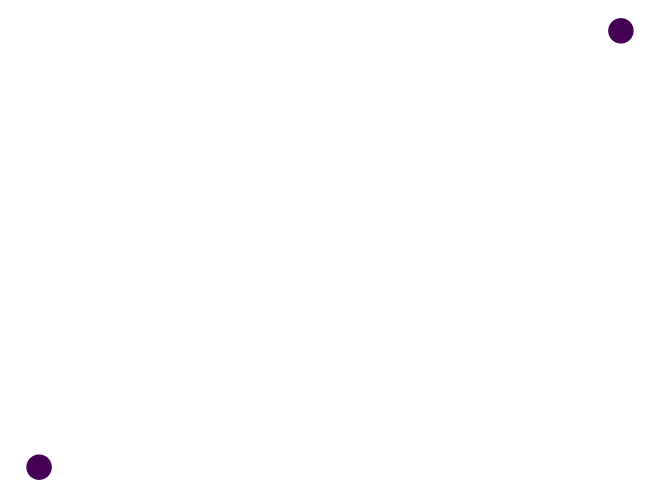

[(0, (0.0, inf)), (0, (0.0, inf))]

In [146]:
height = ripsdata[:,2]
filt2d = np.hstack([height[:,np.newaxis],ripsdata[:,0:1]])

cover_complex = MapperComplex(
    input_type='point cloud', min_points_per_node=0,
    clustering=None, N=100, beta=0., C=10,
    filter_bnds=None, resolutions=[20, 2], gains=None, verbose=True)
_ = cover_complex.fit(ripsdata, filters=filt2d, colors=filt2d)
G = cover_complex.get_networkx()
plt.figure()
nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color=[cover_complex.node_info_[v]["colors"][0] for v in G.nodes()])
plt.show()
test = cover_complex.simplex_tree_
test.persistence(homology_coeff_field = 2, persistence_dim_max =  True)